In [1]:
import pandas as pd
import numpy as np
import random

import librosa

import os

import wandb

from tqdm import tqdm

import matplotlib as mpl
import matplotlib.pylab as plt
import matplotlib.patches as mpatches
import seaborn as sns

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import torch.optim as optim
import torch.nn.functional as F

from scipy import signal

import gc

from src.styles import set_styles, PALETTE
from src.experiment import experiment, continue_experiment, dataloaders_dict, model_dict

import warnings
warnings.filterwarnings("ignore")

SEED=42

In [2]:
# ---- REPRODICIBILITY ------------------------------------------------
np.random.seed(SEED)
random.seed(SEED)


# ---- PANDAS ---------------------------------------------------------
pd.set_option('display.max_columns', None)
pd.options.display.float_format = '{:,.4f}'.format



set_styles()

In [3]:
def target_status(row):
    num_annot = row.iloc[-6:].sum()
    if (num_annot < 3):
        return 'weak'
    
    row = row.iloc[-6:] / num_annot
    delta = 2. / num_annot
    if (row.iloc[-6:] == 1).any():
        return 'ideal'
    elif (row['other_vote'] >= (0.5 - delta)) & (row['other_vote'] <= (0.5 + delta)) & (row.iloc[-6:-1] == (1. - row['other_vote'])).any():
        return 'proto'
    elif (row['other_vote'] < delta):
        for i in range(2, 7):
            cur = row.iloc[-i]
            if (cur >= (0.5 - delta)) & (cur <= (0.5 + delta)):
                if ((row.iloc[-6:-i] == (1. - cur)).any()) | ((row.iloc[-i+1:-1] == (1. - cur)).any()):
                    return 'edge'
                
    return 'weak'

In [4]:
path = 'data/train.csv'
df = pd.read_csv(path).sort_values(['eeg_id', 'eeg_label_offset_seconds'])
dif = df['eeg_label_offset_seconds'] - df['eeg_label_offset_seconds'].shift(1)
df = df.loc[~((dif > 0) & (dif < 50))].reset_index(drop=True) # use only different events

num_annotators = df.iloc[:, -6:].sum(axis=1)
status = df.apply(lambda row: target_status(row), axis=1)

df.insert(df.shape[1] - 7, 'num_annotators', num_annotators)
df.insert(df.shape[1] - 7, 'status', status)

df_bad_ch = pd.read_csv('data/num_bad_channels.csv')
df.insert(df.shape[1] - 7, 'num_bad_channels', df_bad_ch['num_bad_channels'])

df

,eeg_id,eeg_sub_id,eeg_label_offset_seconds,spectrogram_id,spectrogram_sub_id,spectrogram_label_offset_seconds,label_id,patient_id,num_annotators,status,num_bad_channels,expert_consensus,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote
0,568657,0,0.0000,789577333,0,0.0000,1825637311,20654,12,weak,0,Other,0,0,3,0,2,7
1,582999,0,0.0000,1552638400,0,0.0000,1722186807,20230,14,weak,0,LPD,0,12,0,1,0,1
2,642382,0,0.0000,14960202,12,"1,008.0000",3254468733,5955,1,weak,1,Other,0,0,0,0,0,1
3,751790,0,0.0000,618728447,4,908.0000,2898467035,38549,1,weak,0,GPD,0,0,1,0,0,0
4,778705,0,0.0000,52296320,0,0.0000,3255875127,40955,2,weak,2,Other,0,0,0,0,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17084,4293354003,0,0.0000,1188113564,0,0.0000,447244163,16610,2,weak,0,GRDA,0,0,0,0,1,1
17085,4293843368,0,0.0000,1549502620,0,0.0000,1618953053,15065,2,weak,0,GRDA,0,0,0,0,1,1
17086,4294455489,0,0.0000,2105480289,0,0.0000,469526364,56,1,weak,0,Other,0,0,0,0,0,1
17087,4294858825,0,0.0000,657299228,0,0.0000,561576493,4312,15,weak,0,Other,0,0,0,0,1,14


In [5]:
SR = 200
LEN_SEC = 50
DPI=100

def display_eegs(data, label, offset=0):

    df = data.loc[int(offset*SR): int((offset+LEN_SEC)*SR), :]

    fig, ax = plt.subplots(1,1, figsize=(16, 6), dpi=100)

    # display all channels
    for i, col in enumerate(df.columns):
        sns.lineplot(x=np.linspace(0, df.shape[0] // SR, df.shape[0]), y=df[col] / 10 + i, color='black', ax=ax, alpha=0.5, linewidth=1)
        ax.text(-3, i, col)

    # highlight event
    h = df.shape[1] - 1
    w = LEN_SEC
    rect=mpatches.Rectangle((0.4*w,-1),0.2*w,h + 1*2, facecolor=PALETTE[0], alpha=0.3)
    ax.add_patch(rect)

    ax.set_xticks(np.arange(0, 50, 10), np.arange(0, 50, 10))
    ax.grid(axis='x')
        
    ax.set_xlabel('seconds')
    ax.set_ylabel('')
    ax.set_yticklabels([])

    ax.set_title(label, loc='center')
    
    plt.tight_layout()
    plt.show()



def get_diagnosis(dict):
    res = ''
    for k,v in dict.items():
        if v > 0:
            res += '| ' + k[:-5] + ' ' + str(v) + ' |'
    return res

In [28]:
def get_file_sizes(directory):
    files = []
    for f in os.listdir(directory):
        filepath = os.path.join(directory, f)
        if os.path.isfile(filepath) and f.endswith('.parquet'):
            files.append((filepath, os.path.getsize(filepath)))
    
    # Sort the files by size
    sorted_files = sorted(files, key=lambda x: x[1])
    return sorted_files

directory_path = 'data\\train_eegs'
files = get_file_sizes(directory_path)

In [45]:
for file, size in files[:5]:
    print(file.ljust(40), f'{size: ,}'.rjust(10), 'bytes')

print('. . . . .')

for file, size in files[-5:]:
    print(file.ljust(40), f'{size: ,}'.rjust(10), 'bytes')

print(f'\nMedian file size: {np.median([x[1] for x in files]):,.0f} bytes')

data\train_eegs\1457334423.parquet           11,806 bytes
data\train_eegs\1593385762.parquet           39,376 bytes
data\train_eegs\120145971.parquet            54,979 bytes
data\train_eegs\1511903313.parquet           73,094 bytes
data\train_eegs\579740230.parquet            84,251 bytes
. . . . .
data\train_eegs\2860052642.parquet        20,159,585 bytes
data\train_eegs\188361788.parquet         22,265,320 bytes
data\train_eegs\1480985066.parquet        23,170,913 bytes
data\train_eegs\2428433259.parquet        29,201,008 bytes
data\train_eegs\2259539799.parquet        30,247,560 bytes

Median file size: 936,014 bytes


2538961182


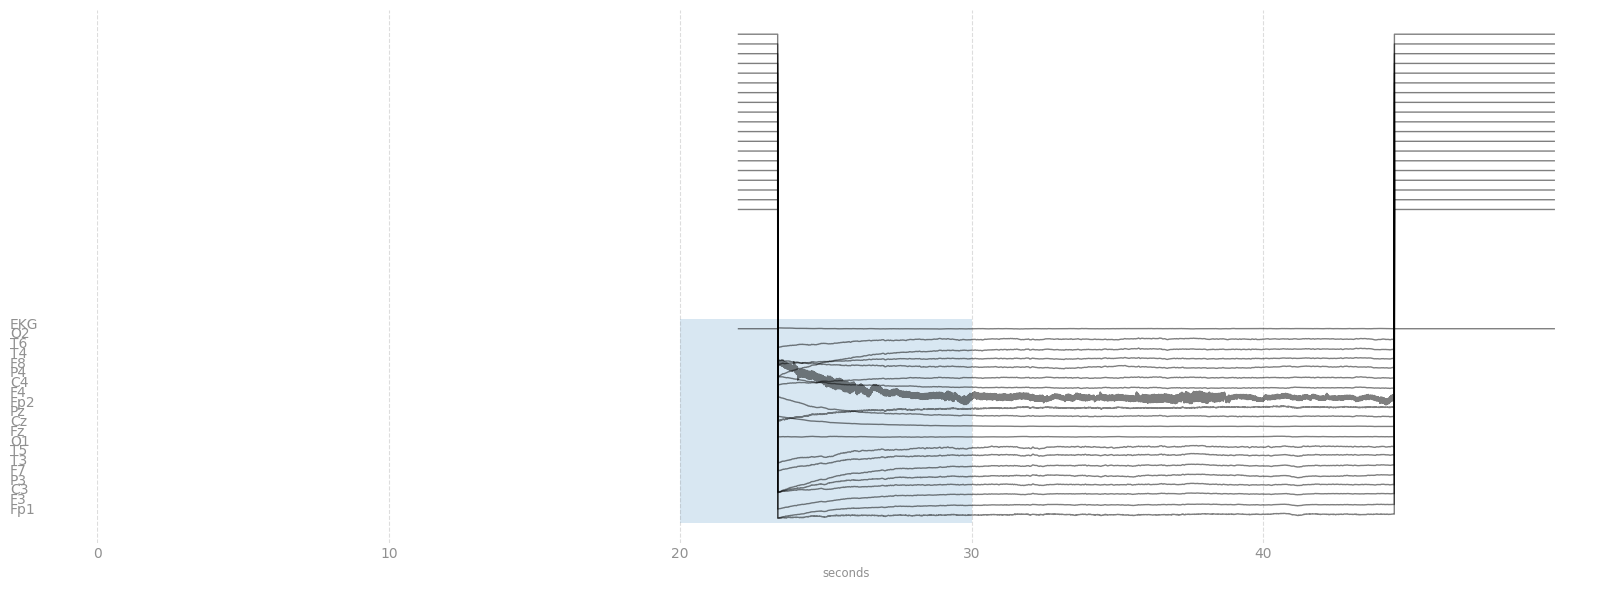

2565199369


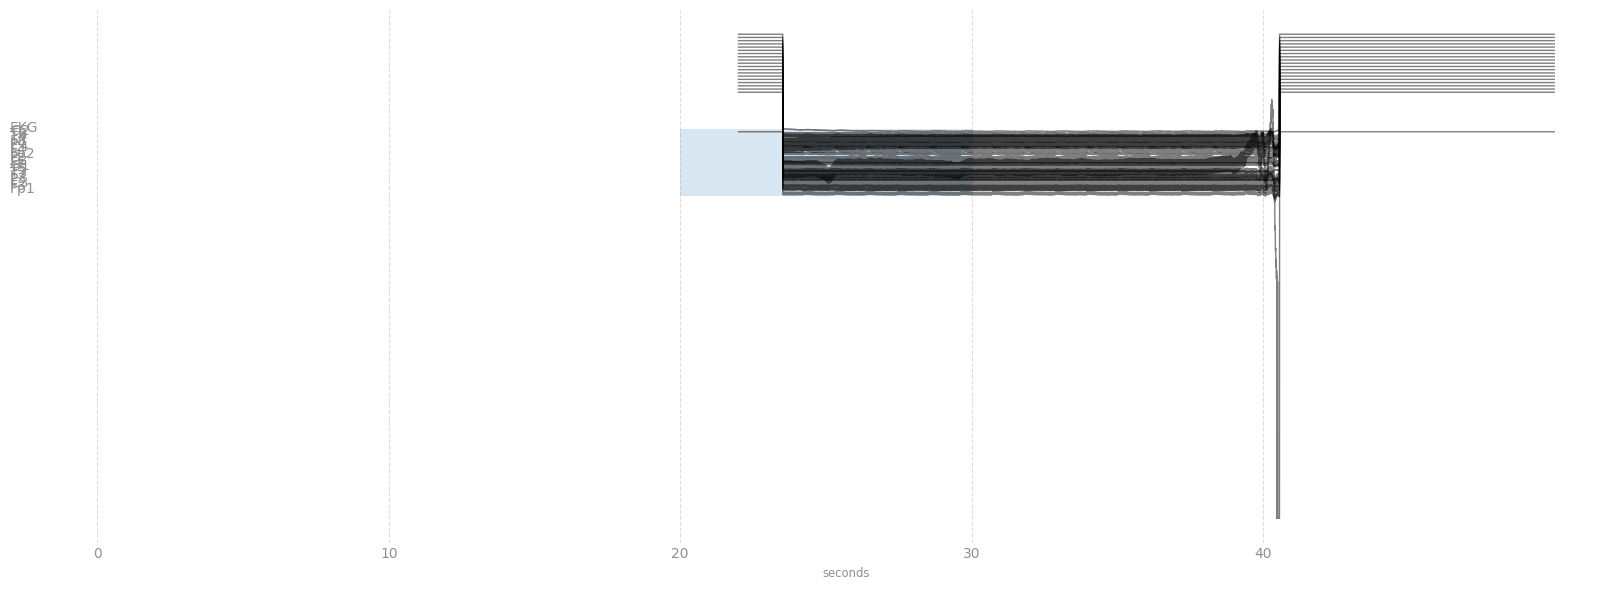

1339041688


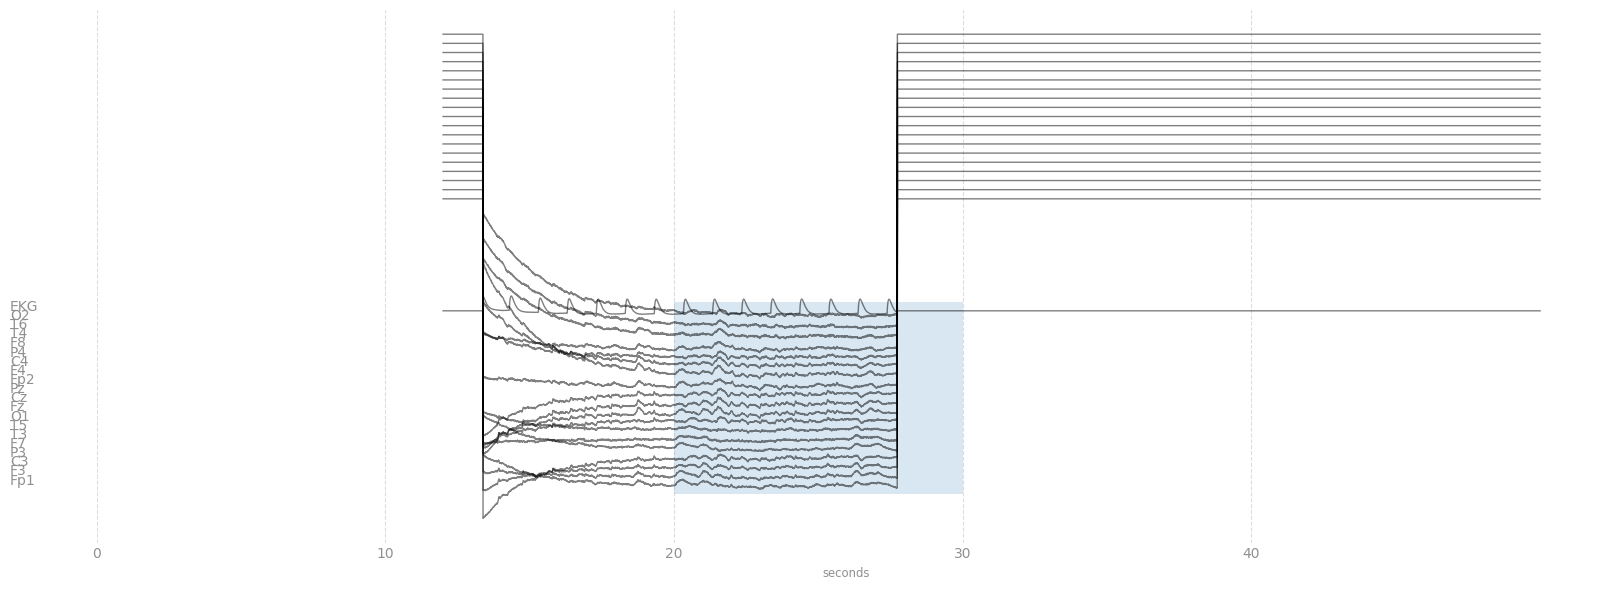

812448735


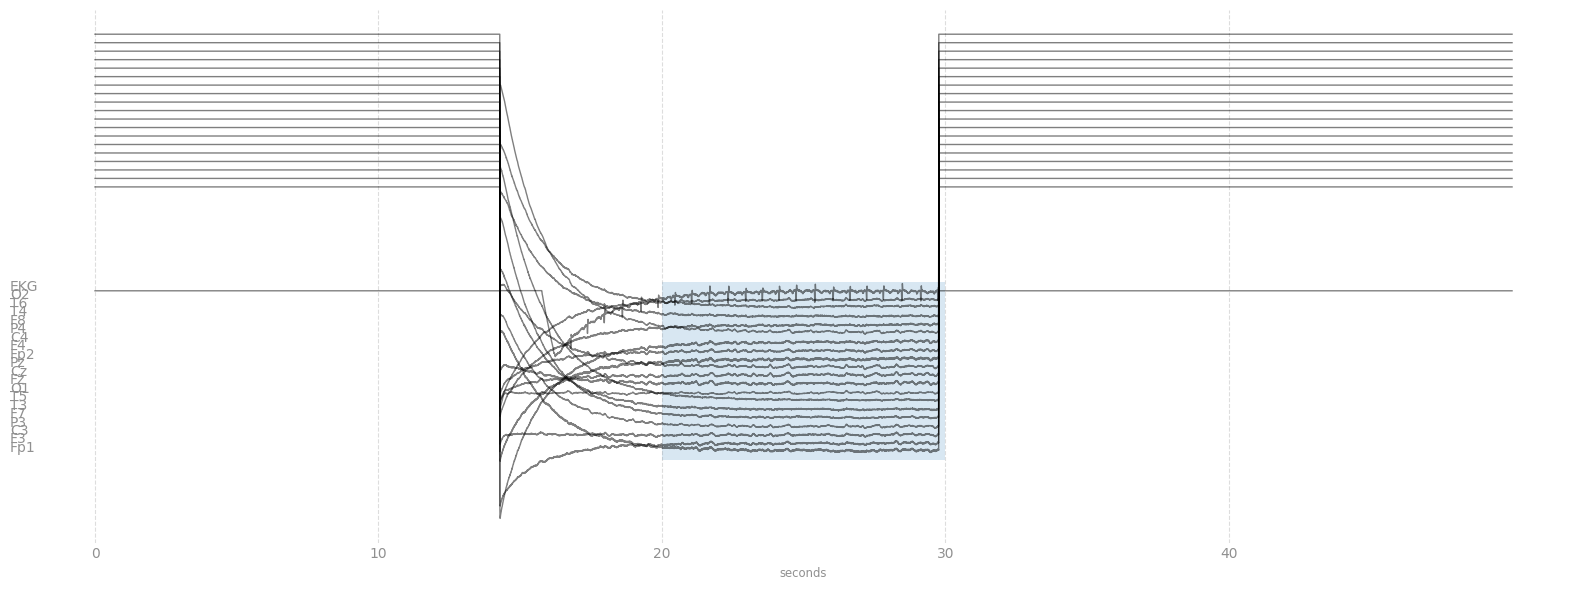

408047047


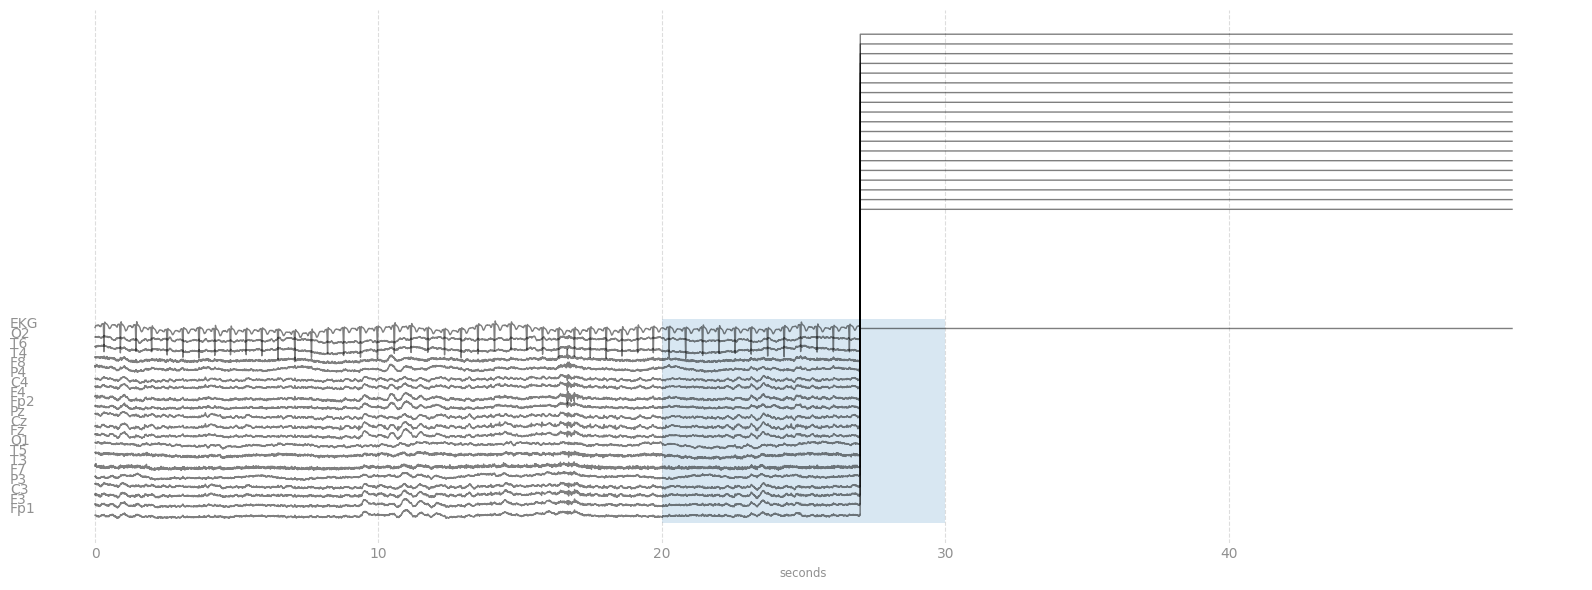

4046938588


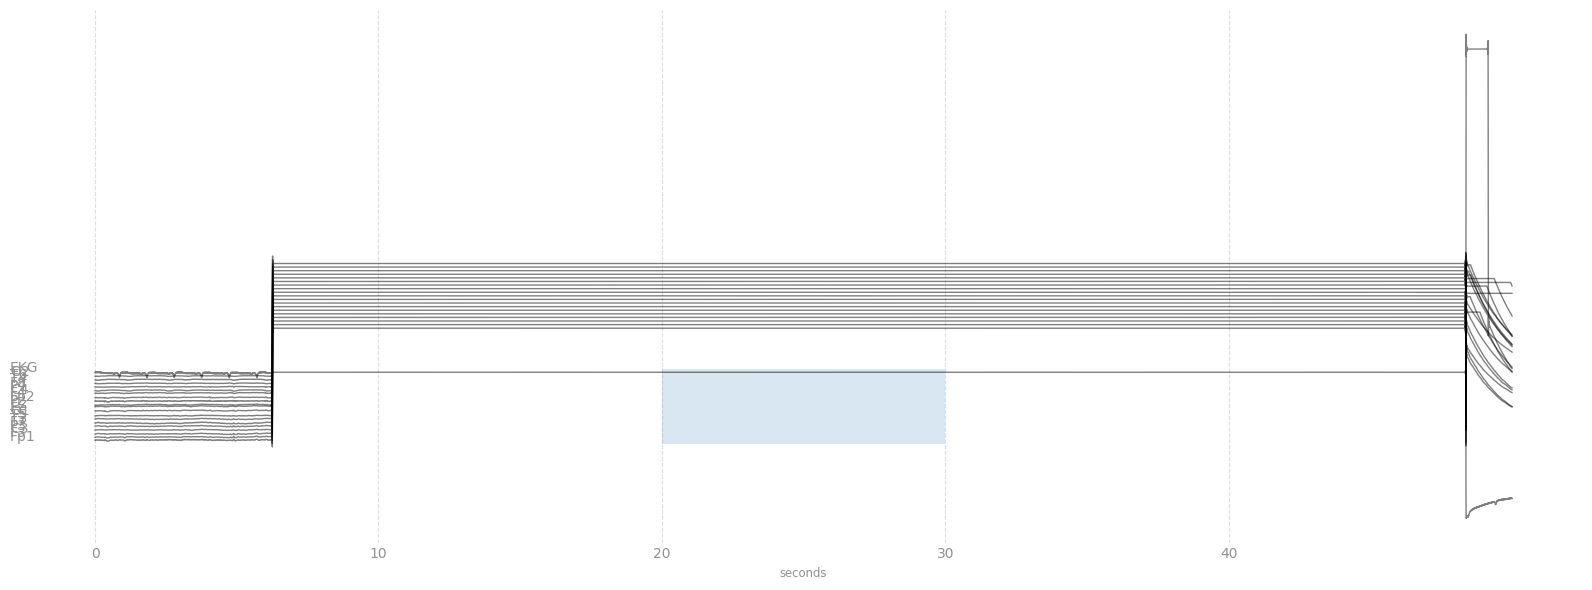

2924540968


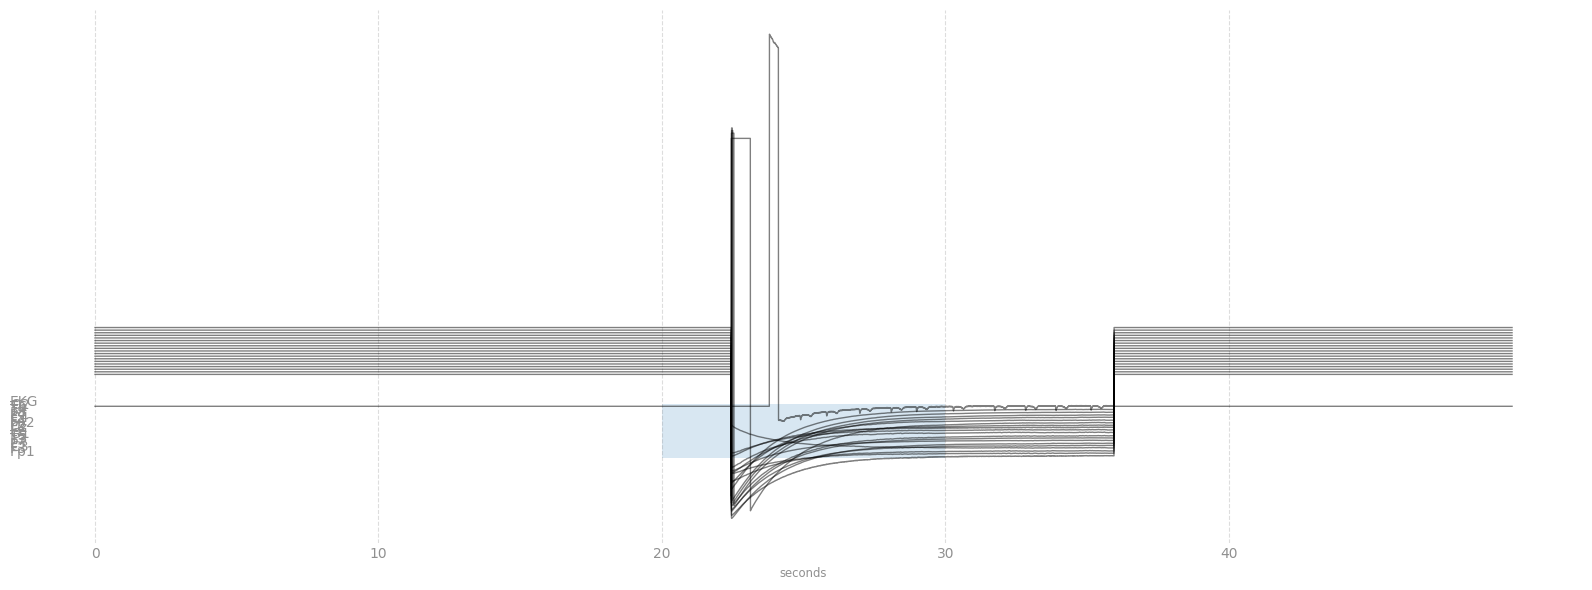

1119914885


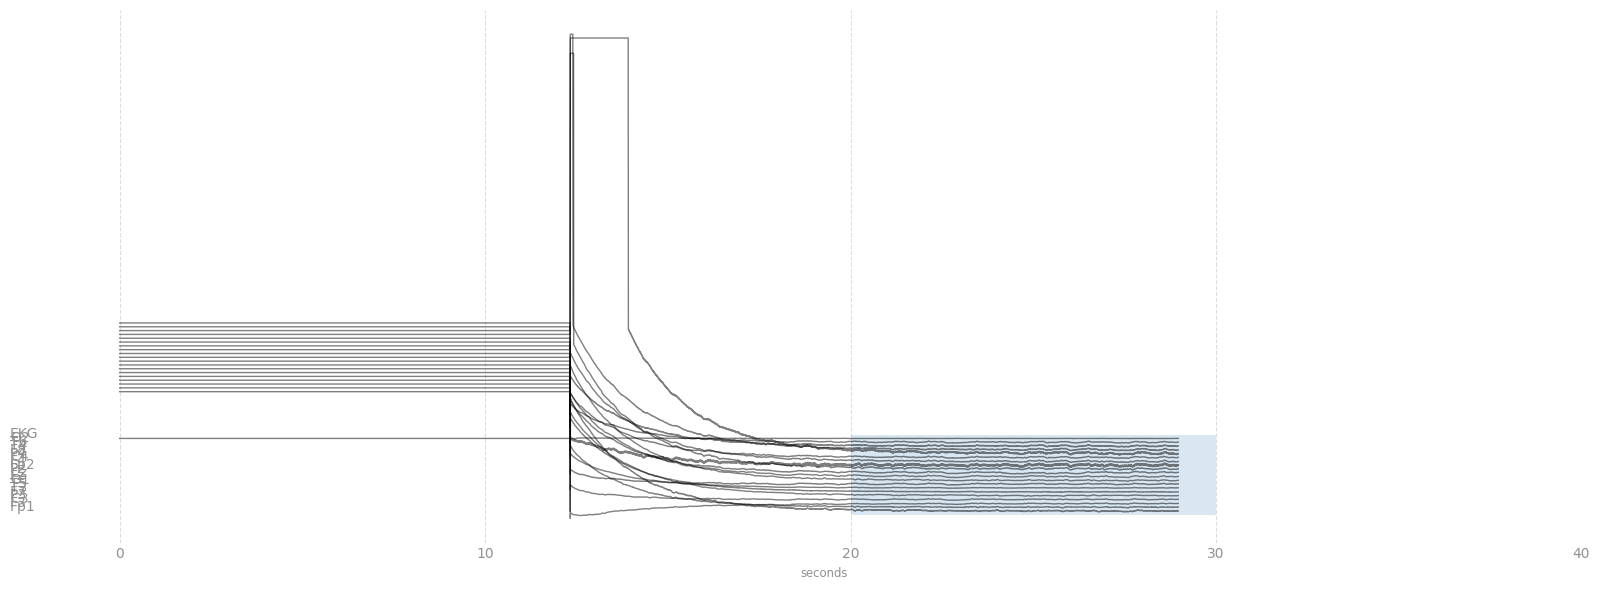

116770645


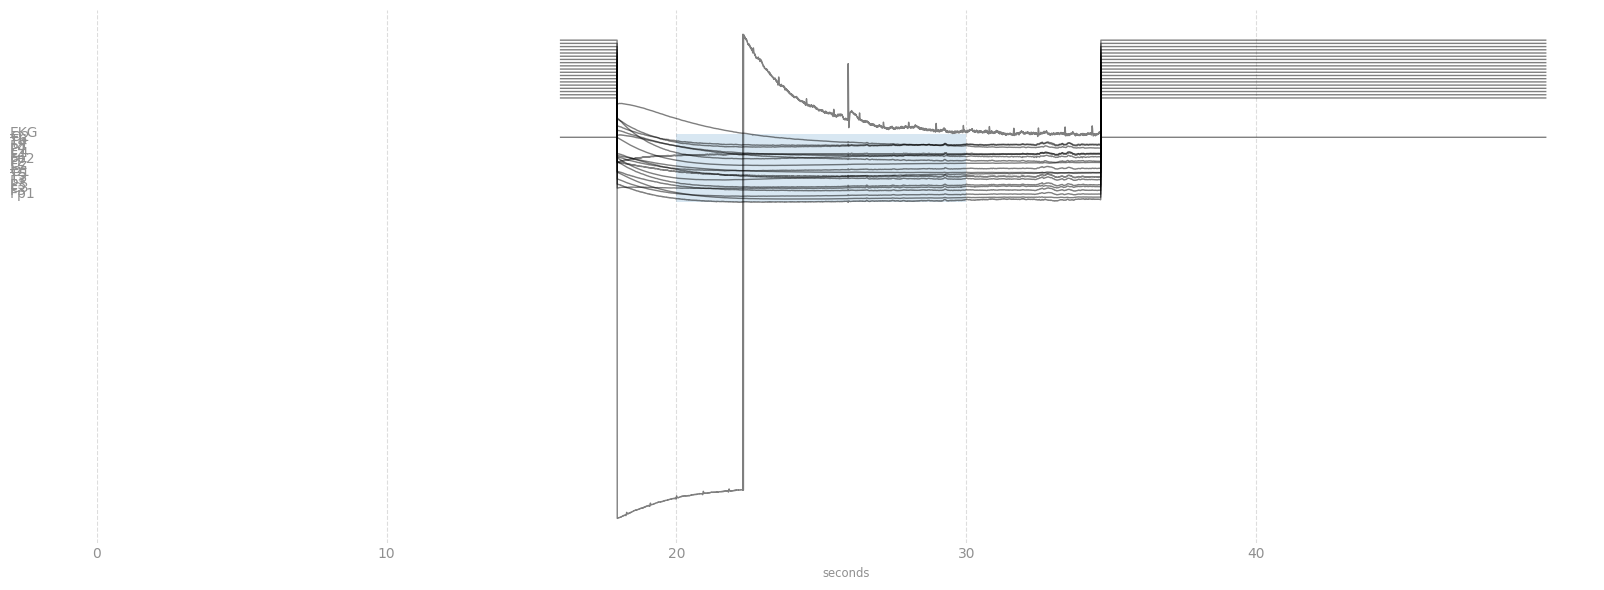

In [6]:
path_eeg = 'data/train_eegs/bad/'

# for eeg_id in [1457334423, 1593385762, 120145971, 1511903313, 579740230, 588638365, 837428467, 2081405553, 3932380488, 1604371226]:
for eeg_id in [2538961182, 2565199369, 1339041688, 812448735, 408047047, 4046938588, 2924540968, 1119914885, 116770645]:
    
    print(eeg_id)
    eeg = pd.read_parquet(path_eeg + f'{eeg_id}.parquet')
    display_eegs(eeg / 32., '')